# Parse /results/

In [1]:
# only works for using NPSR as the algorithm

import os
import numpy as np
import matplotlib.pyplot as plt

print('Datasets in /results/ -', os.listdir('results'))

res = {}
for dset in os.listdir('results'):
    res[dset] = {}
    for algo in os.listdir('results/' + dset):
        assert algo == 'NPSR'
        res[dset][algo] = []
        print(f'Dataset: {dset}, Algorithm: {algo}')
        num_res_files = np.sum(['_result.txt' in file for file in os.listdir(f'results/{dset}/{algo}')])
        if num_res_files >= 1:
            print(f'  Found {num_res_files} result files.')
        else:
            print('  Found no result files. Skipping directory.')
            continue
        
        for fname in os.listdir(f'results/{dset}/{algo}'):
            if '_result.txt' not in fname:
                continue
            res_ent = {}
            res_ent['datetime'] = fname.replace('_result.txt', '')
            with open(f'results/{dset}/{algo}/{fname}', 'r') as file:
                lines = file.readlines()
                lines = [line.replace('\n','') for line in lines]
            res_ent['dset_config'] = lines[0]
            res_ent['model_config'] = lines[1]
            res_ent['epoch'] = []

            epochs = int(res_ent['model_config'].split('epochs=')[-1].split(',')[0])
            lines_per_epoch = (len(lines)-2) // epochs
            for epoch in range(epochs):
                lines_ep = lines[2 + epoch*lines_per_epoch: 2 + (epoch+1)*lines_per_epoch]
                assert lines_ep[0] == f'epoch={epoch}'
                # only record F1 and AUC
                res_ep = {}
                res_ep['M_pt_F1'] = float(lines_ep[1].split('F1:')[-1].split(' ')[0])
                res_ep['M_pt_AUC'] = float(lines_ep[1].split('AUC:')[-1].split(' ')[0])
                res_ep['M_seq_F1'] = float(lines_ep[2].split('F1:')[-1].split(' ')[0])
                res_ep['M_seq_AUC'] = float(lines_ep[2].split('AUC:')[-1].split(' ')[0])
                res_ep['d'] = {}
                for line in lines_ep[3:]:
                    d = int(line.split('d ')[1].split(' ')[0])
                    res_ep['d'][d] = {}
                    tmp = line.split('Soft ')[1].split('  Hard ')
                    tmp = [tmp[0]] + tmp[1].split('  Inf ')
                    tmp = [[float(x) for x in t.replace('F1:', '').split('  AUC:')] for t in tmp]
                    res_ep['d'][d]['Soft F1'] = tmp[0][0]
                    res_ep['d'][d]['Soft AUC'] = tmp[0][1]
                    res_ep['d'][d]['Hard F1'] = tmp[1][0]
                    res_ep['d'][d]['Hard AUC'] = tmp[1][1]
                    res_ep['d'][d]['Inf F1'] = tmp[2][0]
                    res_ep['d'][d]['Inf AUC'] = tmp[2][1]
                res_ent['epoch'].append(res_ep)

            res[dset][algo].append(res_ent)

Datasets in /results/ - ['MSCRED']
Dataset: MSCRED, Algorithm: NPSR
  Found 1 result files.


MSCRED NPSR 20231023_114450
  Namespace(clamp_max=4, clamp_min=-4, dl=50, downsample=1, entities='all', name='MSCRED', stride=10, train_method='train_together', tst_stride='no_rep')
  Namespace(batch_size=64, delta=6, enc_depth=4, epochs=100, ff_mult=4, heads=5, learn_rate=0.0001, name='NPSR', pred_depth=4, pred_dl=50, theta_N_ratio=0.9985, z_dim=4)


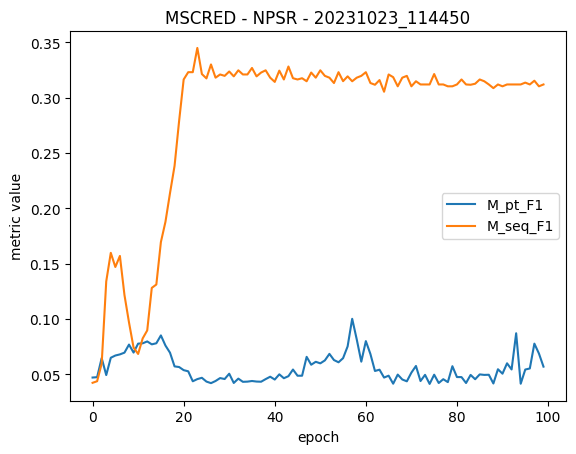

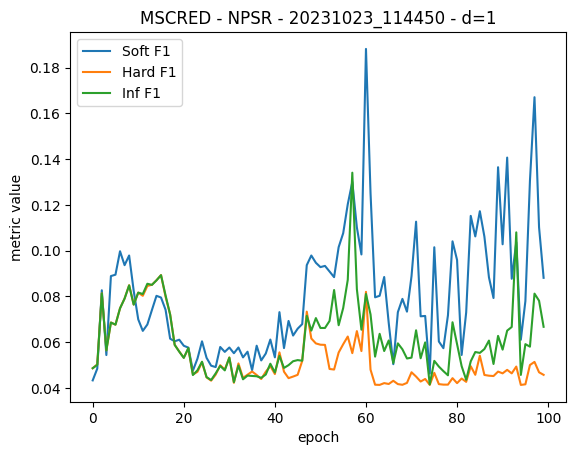

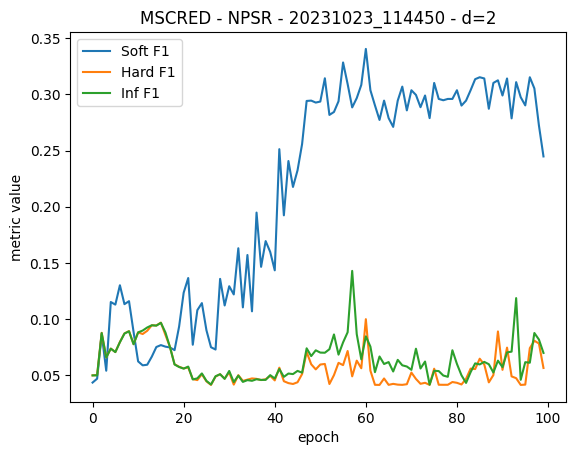

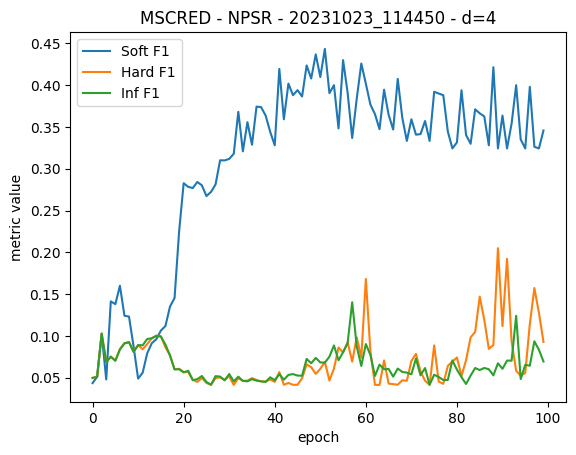

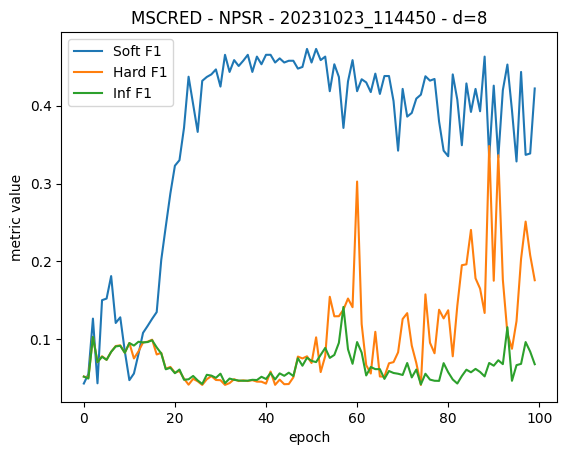

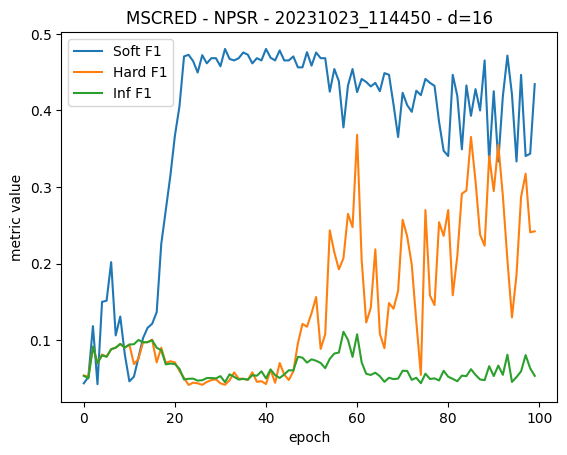

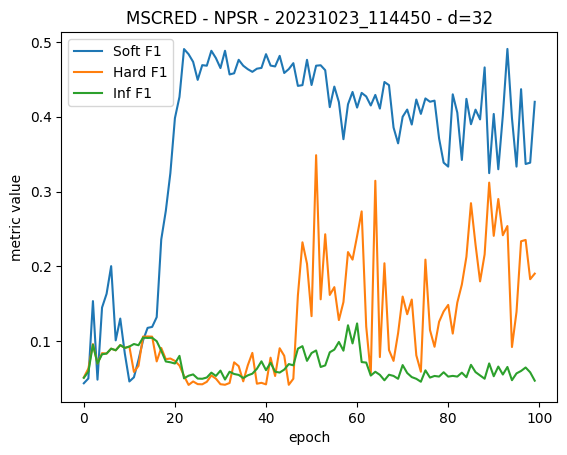

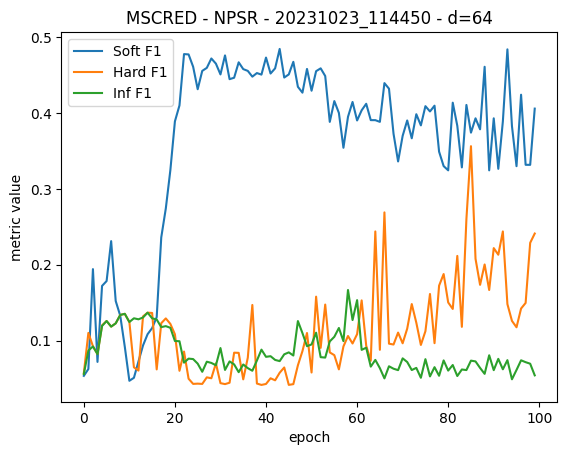

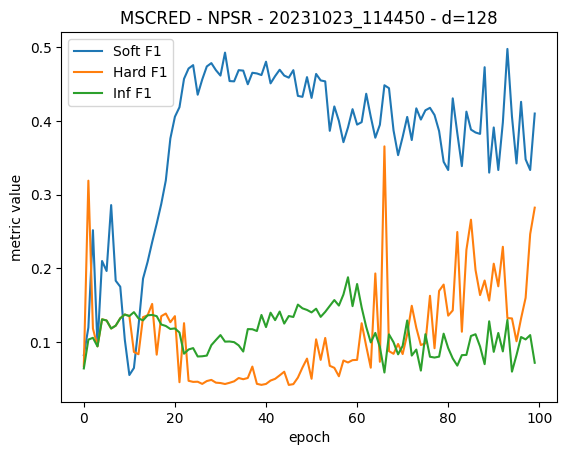

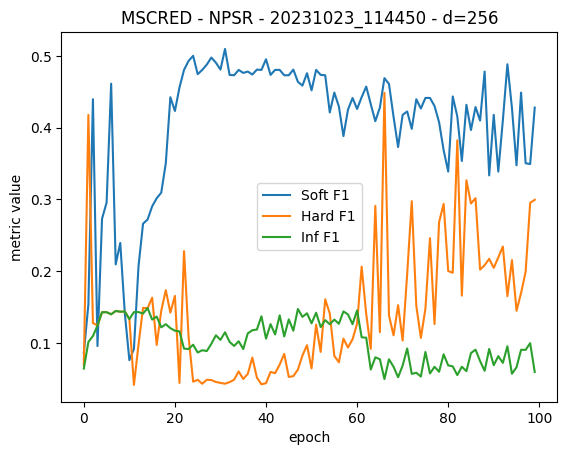

In [2]:
for dset in res.keys():
    for algo in res[dset].keys():
        if len(res[dset][algo]) == 1: # only plot dset + algos with only one result file
            res_ent = res[dset][algo][0]
            print(dset, algo, res_ent['datetime'])
            
            print(f'  {res_ent["dset_config"]}')
            print(f'  {res_ent["model_config"]}')
            
            plt.figure()
            # select which model + metrics to plot
            for plt_name in ['M_pt_F1', 'M_pt_AUC', 'M_seq_F1', 'M_seq_AUC']:
                if 'AUC' in plt_name:
                    continue
                model_metric = [ep[plt_name] for ep in res_ent['epoch']]
                plt.plot(np.arange(len(res_ent['epoch'])), model_metric, label=plt_name)
            plt.legend()
            plt.xlabel('epoch')
            plt.ylabel('metric value')
            plt.title(f'{dset} - {algo} - {res_ent["datetime"]}')
            
            ds = res_ent['epoch'][0]['d'].keys()
            for d in ds:
                plt.figure()
                # select which [Soft, Hard, Inf] + metrics to plot
                for plt_name in ['Soft F1', 'Soft AUC', 'Hard F1', 'Hard AUC', 'Inf F1', 'Inf AUC']:
                    if 'AUC' in plt_name:
                        continue
                    model_metric = [ep['d'][d][plt_name] for ep in res_ent['epoch']]
                    plt.plot(np.arange(len(res_ent['epoch'])), model_metric, label=plt_name)
                plt.legend()
                plt.xlabel('epoch')
                plt.ylabel('metric value')
                plt.title(f'{dset} - {algo} - {res_ent["datetime"]} - d={d}')

In [30]:
vals

array([0.18815, 0.34043, 0.4434 , 0.47291, 0.48039, 0.49074, 0.4843 ,
       0.49774, 0.50962])

In [33]:
# tmp just for MSCRED synthetic dataset
eps = res['MSCRED']['NPSR'][0]['epoch']

mets = ['M_pt_F1', 'M_pt_AUC', 'M_seq_F1', 'M_seq_AUC']
for met in mets:
    vals = np.array([ep[met] for ep in eps])
    print(met, vals.max())

mets = ['Inf AUC', 'Inf F1', 'Hard AUC', 'Hard F1', 'Soft AUC', 'Soft F1']
for met in mets:
    vals = [[ep['d'][d_val][met] for d_val in ep['d'].keys()] for ep in eps]
    vals = np.array(vals).max(axis=0)
    print(met, f'{vals.mean():.3f}', f'{vals.std():.3f}')
    
eps[0]

M_pt_F1 0.1002
M_pt_AUC 0.72105
M_seq_F1 0.34483
M_seq_AUC 0.83189
Inf AUC 0.785 0.037
Inf F1 0.144 0.021
Hard AUC 0.791 0.069
Hard F1 0.292 0.121
Soft AUC 0.862 0.063
Soft F1 0.434 0.099


{'M_pt_F1': 0.04715,
 'M_pt_AUC': 0.50479,
 'M_seq_F1': 0.04238,
 'M_seq_AUC': 0.44264,
 'd': {1: {'Soft F1': 0.04334,
   'Soft AUC': 0.46423,
   'Hard F1': 0.04866,
   'Hard AUC': 0.50018,
   'Inf F1': 0.04865,
   'Inf AUC': 0.50005},
  2: {'Soft F1': 0.04345,
   'Soft AUC': 0.43862,
   'Hard F1': 0.04985,
   'Hard AUC': 0.50007,
   'Inf F1': 0.04983,
   'Inf AUC': 0.49975},
  4: {'Soft F1': 0.04356,
   'Soft AUC': 0.4158,
   'Hard F1': 0.0498,
   'Hard AUC': 0.5008,
   'Inf F1': 0.04976,
   'Inf AUC': 0.50013},
  8: {'Soft F1': 0.04316,
   'Soft AUC': 0.40745,
   'Hard F1': 0.05212,
   'Hard AUC': 0.50044,
   'Inf F1': 0.05201,
   'Inf AUC': 0.49903},
  16: {'Soft F1': 0.04349,
   'Soft AUC': 0.41635,
   'Hard F1': 0.05355,
   'Hard AUC': 0.50087,
   'Inf F1': 0.05328,
   'Inf AUC': 0.49781},
  32: {'Soft F1': 0.04357,
   'Soft AUC': 0.43896,
   'Hard F1': 0.05147,
   'Hard AUC': 0.51947,
   'Inf F1': 0.05085,
   'Inf AUC': 0.51269},
  64: {'Soft F1': 0.05353,
   'Soft AUC': 0.48171,

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

Text(0.5, 1.0, 'MSCRED - NPSR')

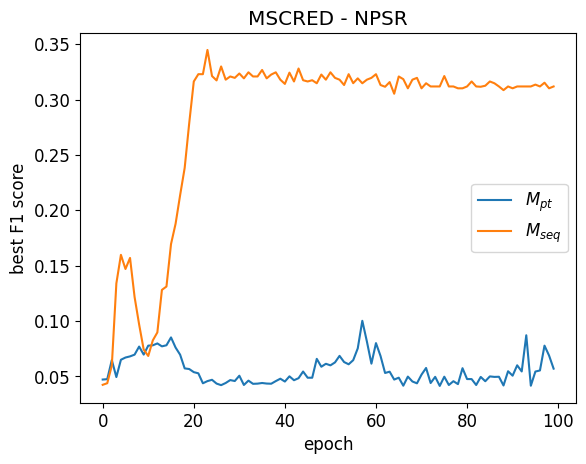

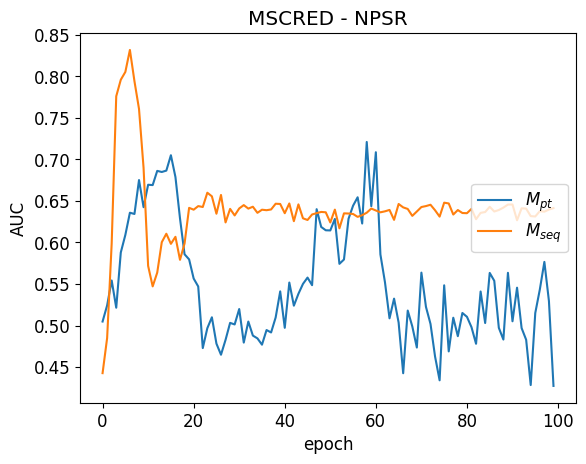

In [4]:
plt.figure()
plt.plot(np.arange(len(res_ent['epoch'])), [ep['M_pt_F1'] for ep in res_ent['epoch']], label='$M_{pt}$')
plt.plot(np.arange(len(res_ent['epoch'])), [ep['M_seq_F1'] for ep in res_ent['epoch']], label='$M_{seq}$')
    
plt.legend(loc=5)
plt.xlabel('epoch')
plt.ylabel('best F1 score')
plt.title(f'{dset} - {algo}')

plt.figure()
plt.plot(np.arange(len(res_ent['epoch'])), [ep['M_pt_AUC'] for ep in res_ent['epoch']], label='$M_{pt}$')
plt.plot(np.arange(len(res_ent['epoch'])), [ep['M_seq_AUC'] for ep in res_ent['epoch']], label='$M_{seq}$')
    
plt.legend(loc=5)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title(f'{dset} - {algo}')

### $\verb|res|$ contains all training results

In [5]:
res

{'MSCRED': {'NPSR': [{'datetime': '20231023_114450',
    'dset_config': "Namespace(clamp_max=4, clamp_min=-4, dl=50, downsample=1, entities='all', name='MSCRED', stride=10, train_method='train_together', tst_stride='no_rep')",
    'model_config': "Namespace(batch_size=64, delta=6, enc_depth=4, epochs=100, ff_mult=4, heads=5, learn_rate=0.0001, name='NPSR', pred_depth=4, pred_dl=50, theta_N_ratio=0.9985, z_dim=4)",
    'epoch': [{'M_pt_F1': 0.04715,
      'M_pt_AUC': 0.50479,
      'M_seq_F1': 0.04238,
      'M_seq_AUC': 0.44264,
      'd': {1: {'Soft F1': 0.04334,
        'Soft AUC': 0.46423,
        'Hard F1': 0.04866,
        'Hard AUC': 0.50018,
        'Inf F1': 0.04865,
        'Inf AUC': 0.50005},
       2: {'Soft F1': 0.04345,
        'Soft AUC': 0.43862,
        'Hard F1': 0.04985,
        'Hard AUC': 0.50007,
        'Inf F1': 0.04983,
        'Inf AUC': 0.49975},
       4: {'Soft F1': 0.04356,
        'Soft AUC': 0.4158,
        'Hard F1': 0.0498,
        'Hard AUC': 0.5008,


In [6]:
import numpy as np
from utils import evaluation as e
import matplotlib.pyplot as plt

N = np.load('results/N.npy')
A = np.load('results/A.npy')
L = np.load('results/L.npy')

tN_p985 = 2.4219597474702477
tN_maxN_anomaly = N[L == 1].max()
d = 16

FileNotFoundError: [Errno 2] No such file or directory: 'results/N.npy'

In [ ]:

F1s_hard_d_1 = []
for thres_log in thress_log:
    IA = e.get_induced_anomaly_score(N, A, np.exp(thres_log), 1, gate_func='hard')
    F1 = e.get_bestF1(L, IA)['F1']
    F1s_hard_d_1.append(F1)
F1s_hard_d_1 = np.array(F1s_hard_d_1)

In [ ]:
thress_log = np.linspace(np.log(N.min()), np.log(N.max()), 100)
F1s_soft = []
FPRs_soft = []
for thres_log in thress_log:
    IA = e.get_induced_anomaly_score(N, A, np.exp(thres_log), d)
    F1 = e.get_bestF1(L, IA)['F1']
    FPR = e.get_bestF1(L, IA)['FPR']
    F1s_soft.append(F1)
    FPRs_soft.append(FPR)
F1s_soft = np.array(F1s_soft)
FPRs_soft = np.array(FPRs_soft)

F1s_hard = []
FPRs_hard = []
for thres_log in thress_log:
    IA = e.get_induced_anomaly_score(N, A, np.exp(thres_log), d, gate_func='hard')
    F1 = e.get_bestF1(L, IA)['F1']
    FPR = e.get_bestF1(L, IA)['FPR']
    F1s_hard.append(F1)
    FPRs_hard.append(FPR)
F1s_hard = np.array(F1s_hard)
FPRs_hard = np.array(FPRs_hard)

F1_point = e.get_bestF1(L, A)['F1']
FPR_point = e.get_bestF1(L, A)['FPR']

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, width_ratios=(0.58, 0.15, 0.15, 0.12), figsize=(14,7))
ax[0].scatter(A[L == 0], N[L == 0], c='g', label='Normal')
ax[0].scatter(A[L == 1], N[L == 1], c='r', label='Anomaly')
ax[0].plot([A.min(), A.max()], [tN_p985, tN_p985], c='black', label='98.5% θNtrn')
ax[1].plot(F1s_hard, np.exp(thress_log), label=f'hard')
ax[1].plot(F1s_soft, np.exp(thress_log), label=f'soft')
ax[2].plot(FPRs_hard, np.exp(thress_log), label=f'hard')
ax[2].plot(FPRs_soft, np.exp(thress_log), label=f'soft')
ax[3].plot(F1s_hard_d_1, np.exp(thress_log), label=f'hard')
ax[1].plot([F1_point]*2, [N.min(), N.max()], '--', c='black', label='point')
ax[2].plot([FPR_point]*2, [N.min(), N.max()], '--', c='black', label='point')
ax[3].plot([F1_point]*2, [N.min(), N.max()], '--', c='black', label='point')
ax[0].set_xlabel('Anomaly score (point-based)')
ax[1].set_xlabel('best F1 (d=16)')
ax[2].set_xlabel('FPR (d=16)')
ax[3].set_xlabel('best F1 (d=1)')
ax[0].set_ylabel('Nominality score')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc=2)
ax[1].legend(loc=4)
ax[2].legend(loc=4)
ax[3].legend(loc=4)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, width_ratios=(0.7, 0.3), figsize=(14,7))
ax[0].scatter(A[L == 0], N[L == 0], c='g', label='Normal')
ax[0].scatter(A[L == 1], N[L == 1], c='r', label='Anomaly')
ax[0].plot([A.min(), A.max()], [tN_maxN_anomaly, tN_maxN_anomaly], c='black', label='Max θN (anomaly)')
# ax[1].plot(F1s_soft, np.exp(thress_log), label=f'soft')
ax[1].plot(F1s_hard, np.exp(thress_log), label=f'hard')
ax[1].plot([F1_point]*2, [N.min(), N.max()], '--', c='black', label='point')
ax[0].set_xlabel('Anomaly score (point-based)')
ax[1].set_xlabel('best F1 score')
ax[0].set_ylabel('Nominality score')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc=2)
ax[1].legend(loc=4)
fig.tight_layout()

In [ ]:
F1_point, F1s_soft.max()